In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.io import loadmat
from tqdm import tqdm
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Pfad zum gewünschten Ordner auf deinem Google Drive
folder_path = '/content/drive/MyDrive/DataTraining/'

# Liste alle Dateien und Ordner im angegebenen Pfad auf
contents = os.listdir(folder_path)

# Gehe alle Dateien und Ordner durch und drucke sie aus
for item in contents:
    print(item)

csv_path = os.path.join(folder_path, 'Fulldata_age.csv')
df = pd.read_csv(csv_path)

Mounted at /content/drive
Fulldata.csv
Fulldata_age.csv
ergebnisse_grid.csv
ergebnisse_rand.csv
ergebnisse_rand_1.csv
ergebnisse_reg_NC.csv
ergebnisse_reg_SoH.csv
ergebnisse_reg.csv
ergebnisse_best.csv
ergebnisse_best_1.csv
pred_best.csv


In [15]:
full_df = df.sample(frac=0.1, random_state=42)

train_df = full_df.copy()
train_df = train_df[train_df['Value_SoH'] > 0.79]
#train_df = train_df[train_df['Folder'] == 1]
#Dropable Columns
training_columns = ['Time','Value_U','Value_I','Value_SoC','Value_SoH','Cumulative_Ah','Value_Age','Value_NumCharge','Value_NcT80']
#training_columns = ['Value_SoH','Value_NumCharge','Value_Age','Value_NcT80']
train_df = train_df[training_columns]
train_df.info()
train_df.head()

#Prediciton Columns
pred_columns = ['Value_SoH','Value_NcT80']
pred_column = ['Value_NcT80']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 161015 entries, 119162 to 1119089
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             161015 non-null  int64  
 1   Value_U          161015 non-null  float64
 2   Value_I          161015 non-null  float64
 3   Value_SoC        161015 non-null  float64
 4   Value_SoH        161015 non-null  float64
 5   Cumulative_Ah    161015 non-null  float64
 6   Value_Age        161015 non-null  int64  
 7   Value_NumCharge  161015 non-null  int64  
 8   Value_NcT80      161015 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 12.3 MB


Value_SoH
Time              -0.001372
Value_U           -0.020421
Value_I            0.021878
Value_SoC         -0.002235
Value_SoH          1.000000
Cumulative_Ah     -0.907096
Value_Age         -0.728028
Value_NumCharge   -0.822768
Value_NcT80        0.863706
Name: Value_SoH, dtype: float64
Value_NcT80
Time              -0.098556
Value_U           -0.123344
Value_I            0.020883
Value_SoC         -0.073026
Value_SoH          0.863706
Cumulative_Ah     -0.685344
Value_Age         -0.743395
Value_NumCharge   -0.563778
Value_NcT80        1.000000
Name: Value_NcT80, dtype: float64


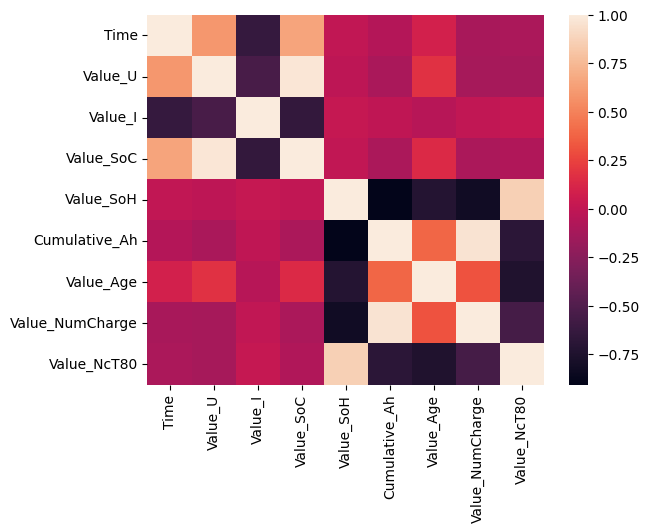

In [16]:
corr = train_df.corr()
fig, ax = plt.subplots()
sns.heatmap(corr)
for col in pred_columns:
  print(col)
  print(corr[col])


In [17]:
from sklearn.model_selection import train_test_split

X = dict()
y = dict()
X_train = dict()
meta =dict()
X_test = dict()
y_train = dict()
y_test = dict()
y_pred = dict()

In [18]:
X = train_df.drop(pred_columns,axis=1)
y_columns = pred_column
y = train_df[y_columns]
print(y.shape,X.shape)



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Value_Age'])
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,   test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.info()
y_train.info()

(161015, 1) (161015, 7)
(112710, 7) (24152, 7) (112710, 1) (24152, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112710 entries, 1372113 to 1391191
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             112710 non-null  int64  
 1   Value_U          112710 non-null  float64
 2   Value_I          112710 non-null  float64
 3   Value_SoC        112710 non-null  float64
 4   Cumulative_Ah    112710 non-null  float64
 5   Value_Age        112710 non-null  int64  
 6   Value_NumCharge  112710 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 6.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112710 entries, 1372113 to 1391191
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Value_NcT80  112710 non-null  float64
dtypes: float64(1)
memory usage: 1.7 MB


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
y_val_scaled = scaler_y.transform(y_val)

In [10]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import plot_model

In [20]:
ergebnis_columns = ['Params','MAE','MSE']
ergebnis_df = pd.DataFrame(columns=ergebnis_columns)

# Schritt 1: Importieren der erforderlichen Bibliotheken
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Schritt 2: Definieren der Pipeline mit LinearRegression
linreg = LinearRegression()

# Schritt 3: Das Modell auf den Trainingsdaten trainieren
linreg.fit(X_train_scaled, y_train_scaled)

# Schritt 4: Vorhersagen auf den Validierungsdaten durchführen
y_pred_scaled = linreg.predict(X_test_scaled)

# Schritt 5: Modellleistung auf den Validierungsdaten bewerten
mse_val = mean_squared_error(y_test_scaled, y_pred_scaled)
mae_val = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2_val = r2_score(y_test_scaled, y_pred_scaled)
print(f'MSE auf den Validierungsdaten: {mse_val}')
print(f'MAE auf den Validierungsdaten: {mae_val}')
print(f'R^2 auf den Validierungsdaten: {r2_val}')

num_trainable_parameters = len(linreg.coef_) + 1
print(f'Anzahl der trainierbaren Parameter: {num_trainable_parameters}')

ergebnis_df = pd.DataFrame([[16, mae_val, mse_val]], columns=ergebnis_df.columns)


ergebnis_df.head()
#ergebnis_df.to_csv(folder_path + 'ergebnisse_reg_SoH.csv', index=False)

MSE auf den Validierungsdaten: 0.010975011509324527
MAE auf den Validierungsdaten: 0.07901385068650082
R^2 auf den Validierungsdaten: 0.799846434166071
Anzahl der trainierbaren Parameter: 2


,Params,MAE,MSE
0,16,0.079014,0.010975


In [25]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test.info()
y_pred_df = pd.DataFrame(y_pred, columns=y_columns)
y_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24152 entries, 866015 to 767462
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_NcT80  24152 non-null  float64
dtypes: float64(1)
memory usage: 377.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24152 entries, 0 to 24151
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_NcT80  24152 non-null  float64
dtypes: float64(1)
memory usage: 188.8 KB


In [26]:
y_pred_df.to_csv(folder_path + 'pred_linreg_NC.csv', index=False)

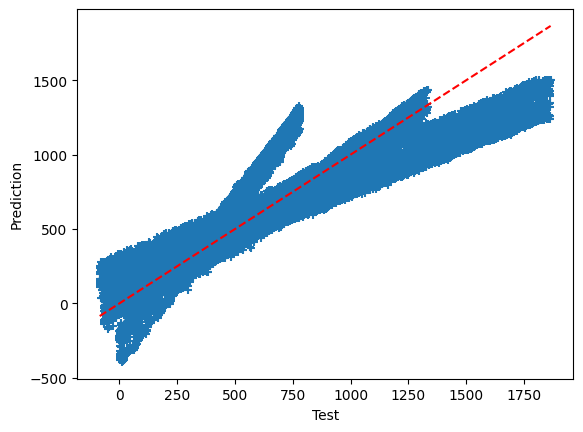

In [27]:
for pred_col in y_columns:
  plt.scatter(y_test[pred_col], y_pred_df[pred_col], marker='+')
  plt.plot([y_test[pred_col].min(), y_test[pred_col].max()], [y_test[pred_col].min(), y_test[pred_col].max()], color='red', linestyle='--')
  plt.xlabel('Test')
  plt.ylabel('Prediction')
  plt.show()


In [104]:
SoH_df = pd.read_csv(folder_path+ 'ergebnisse_reg_SoH.csv')
print(SoH_df)
NC_df = pd.read_csv(folder_path+ 'ergebnisse_reg_NC.csv')
print(SoH_df)
erg_df = pd.concat([NC_df, SoH_df], ignore_index=True)
print(erg_df)
mean_df = pd.DataFrame([[16, erg_df['MAE'].mean(), erg_df['MSE'].mean()]], columns=erg_df.columns)
print(mean_df)
mean_df.to_csv(folder_path + 'ergebnisse_reg.csv', index=False)

   Params       MAE       MSE
0      16  0.013357  0.000368
   Params       MAE       MSE
0      16  0.013357  0.000368
   Params       MAE       MSE
0      16  0.079014  0.010975
1      16  0.013357  0.000368
   Params       MAE       MSE
0      16  0.046186  0.005672
